In [1]:
import numpy as np
import pandas as pd
import gc
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

# Goal
The May edition of the 2022 Tabular Playground series binary classification problem that includes a number of different feature interactions. This competition is an opportunity to explore various methods for identifying and exploiting these feature interactions.

In [2]:
train = pd.read_csv('../input/tabular-playground-series-may-2022/train.csv')
test = pd.read_csv('../input/tabular-playground-series-may-2022/test.csv')
sub = pd.read_csv('../input/tabular-playground-series-may-2022/sample_submission.csv')

print(train.shape)
print(test.shape)
print(sub.shape)

(900000, 33)
(700000, 32)
(700000, 2)


In [3]:
train.head()

,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,target
0,0,-1.373246,0.238887,-0.243376,0.567405,-0.647715,0.839326,0.113133,1,5,1,3,3,3,1,6,1,0,7,4,0.298218,-0.919717,3.058541,-2.540739,0.766952,-2.730628,-0.208177,1.363402,ABABDADBAB,67.609153,0,0,0
1,1,1.697021,-1.710322,-2.230332,-0.545661,1.113173,-1.552175,0.447825,1,3,4,0,2,3,0,1,0,4,6,0,-3.147667,-1.075434,2.179050,2.278315,-0.633658,-1.217077,-3.782194,-0.058316,ACACCADCEB,377.096415,0,0,1
2,2,1.681726,0.616746,-1.027689,0.810492,-0.609086,0.113965,-0.708660,1,0,2,6,6,4,3,1,2,2,1,4,2.820733,-3.485342,-0.784235,-1.385775,-0.520558,-0.009121,2.788536,-3.703488,AAAEABCKAD,-195.599702,0,2,1
3,3,-0.118172,-0.587835,-0.804638,2.086822,0.371005,-0.128831,-0.282575,3,2,1,0,1,6,4,2,3,3,0,3,1.081084,-2.100177,-2.343819,0.572594,-1.653213,1.686035,-2.533098,-0.608601,BDBBAACBCB,210.826205,0,0,1
4,4,1.148481,-0.176567,-0.664871,-1.101343,0.467875,0.500117,0.407515,3,3,0,4,3,0,6,0,3,3,1,0,-0.126179,0.605033,1.133665,-3.912929,-1.430366,2.127649,-3.306784,4.371371,BDBCBBCHFE,-217.211798,0,1,1


# EDA

In [4]:
def eda(df):
    summary = pd.DataFrame()
    summary['miss'] = df.isnull().sum()
    summary['level'] = df.nunique()
    summary['dtype'] = df.dtypes
    return summary

edatrain = eda(train)
edatrain.T

,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,target
miss,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
level,900000,900000,900000,900000,900000,900000,900000,900000,16,16,15,15,14,16,13,14,15,16,14,14,900000,900000,900000,900000,900000,900000,900000,900000,741354,900000,2,3,2
dtype,int64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,int64,int64,int64


In [5]:
eda(test).T

,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30
miss,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
level,700000,700000,700000,700000,700000,700000,700000,700000,16,14,16,16,15,16,14,13,14,14,14,14,700000,700000,700000,700000,700000,700000,700000,700000,598482,700000,2,3
dtype,int64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,int64,int64


### New Levels?

In [6]:
train.f_13.value_counts()

2     233926
1     215260
3     174680
0     102521
4      99712
5      46471
6      18316
7       6378
8       1934
9        626
10       145
11        25
12         6
Name: f_13, dtype: int64

In [7]:
test.f_13.value_counts()

2     182018
1     167469
3     135820
0      79807
4      77447
5      36200
6      14228
7       4970
8       1493
9        403
10       116
11        23
12         4
13         2
Name: f_13, dtype: int64

In [8]:
train.groupby('f_30')['target'].mean()

f_30
0    0.476652
1    0.480685
2    0.501921
Name: target, dtype: float64

In [9]:
train.duplicated().sum()

0

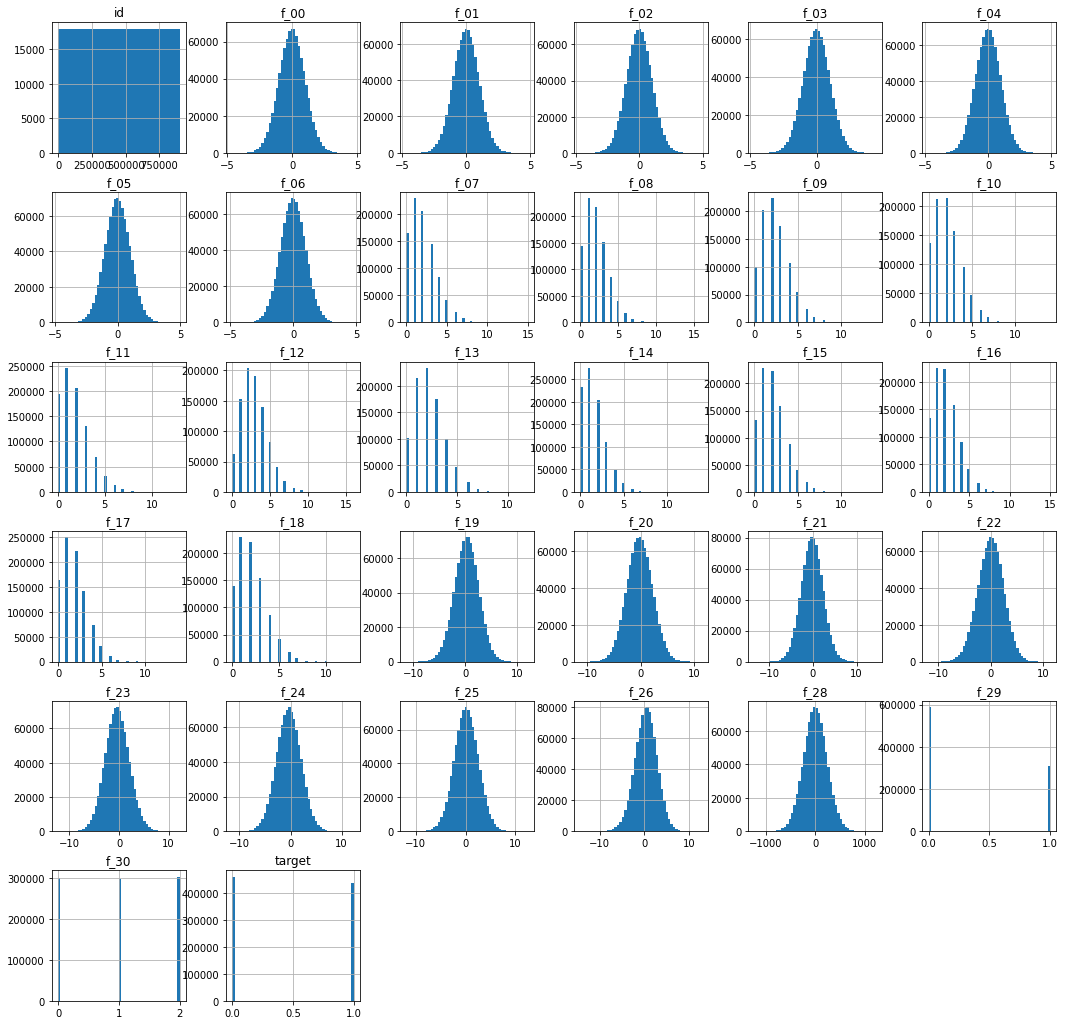

In [10]:
train.hist(figsize = (18,18), bins = 50)
plt.show()

In [11]:
train.target.value_counts()/len(train)

0    0.513512
1    0.486488
Name: target, dtype: float64

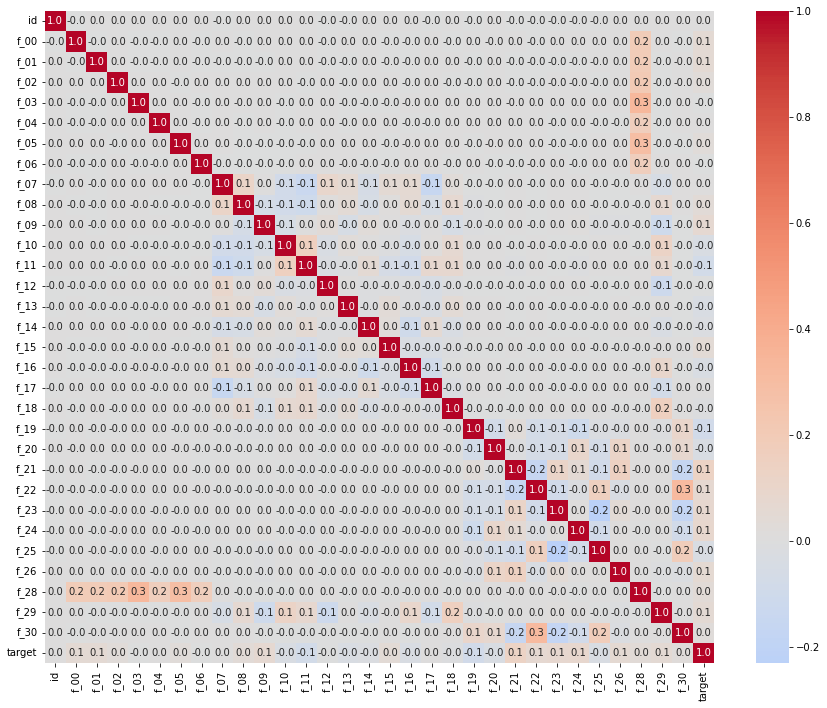

In [12]:
plt.figure(figsize = (15,12))
sns.heatmap(train.corr(), cmap = 'coolwarm',center=0, annot=True, fmt='.1f')
plt.show()

In [13]:
float_fea = [f for f in train.columns if train[f].dtype == 'float64']
float_fea

['f_00',
 'f_01',
 'f_02',
 'f_03',
 'f_04',
 'f_05',
 'f_06',
 'f_19',
 'f_20',
 'f_21',
 'f_22',
 'f_23',
 'f_24',
 'f_25',
 'f_26',
 'f_28']

# Numeric features

16it [00:04,  3.28it/s]


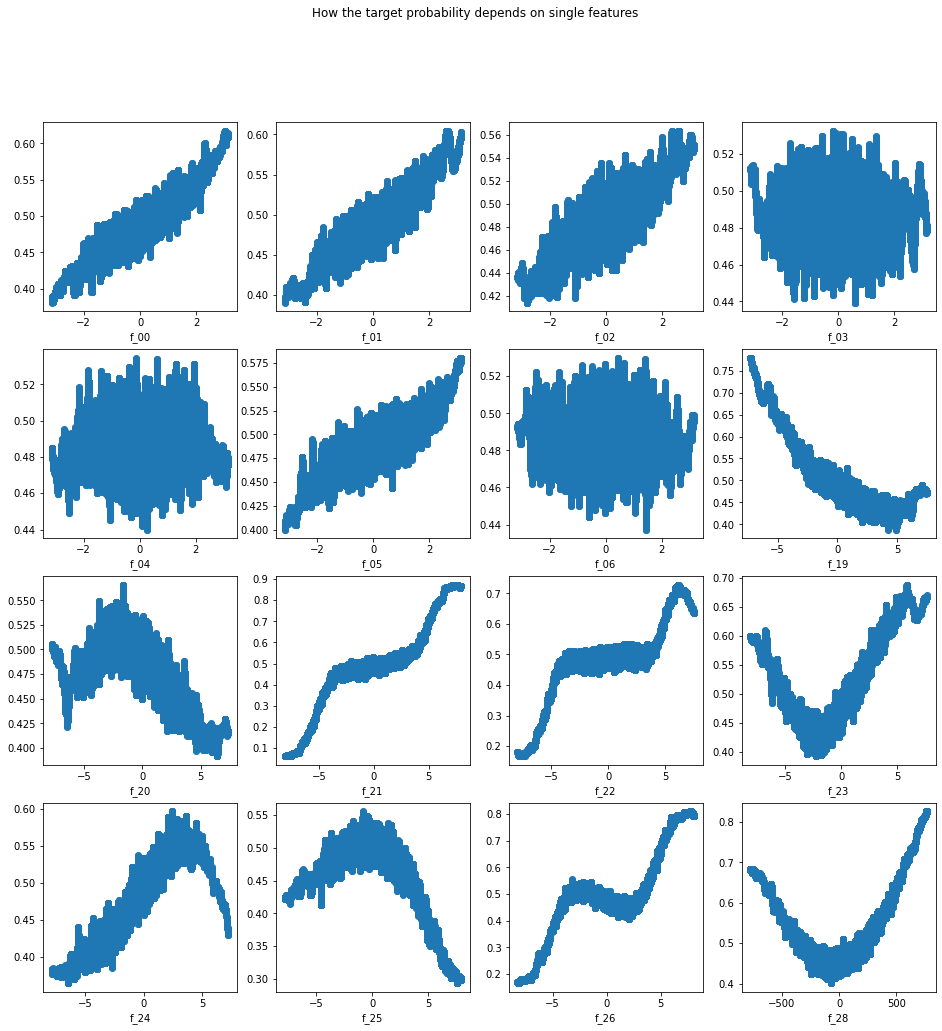

CPU times: user 31.3 s, sys: 277 ms, total: 31.6 s
Wall time: 31.3 s


In [14]:
%%time

fig, axs = plt.subplots(4, 4, figsize=(16, 16))
for f, ax in tqdm(zip(float_fea, axs.ravel())):
    tmp = train[[f, 'target']].sort_values(by = f)
    ax.scatter(tmp[f], tmp.target.rolling(1500, center = True).mean())
    ax.set_xlabel(f'{f}')
plt.suptitle('How the target probability depends on single features')
plt.show()

# F_27

In [15]:
for i in range(10):
    print(f'Position {i} in f_27')
    tg = train.groupby(train.f_27.str.get(i))
    temp = pd.DataFrame({'size': tg.size(), 'probability': tg.target.mean().round(2)})
    print(temp)
    print()

Position 0 in f_27
        size  probability
f_27                     
A     451207         0.54
B     448793         0.44

Position 1 in f_27
        size  probability
f_27                     
A     144762         0.58
B     245160         0.48
C     225931         0.49
D     149579         0.45
E      78807         0.43
F      35487         0.42
G      13713         0.41
H       4647         0.40
I       1361         0.40
J        410         0.38
K        113         0.39
L         25         0.28
M          3         0.67
N          2         1.00

Position 2 in f_27
        size  probability
f_27                     
A     297840         0.53
B     602160         0.46

Position 3 in f_27
        size  probability
f_27                     
A     160839         0.57
B     237218         0.48
C     210015         0.48
D     143633         0.45
E      81662         0.43
F      39504         0.44
G      17121         0.45
H       6473         0.47
I       2379         0.48
J        77

# Correlation Analysis

In [16]:
train.corr()['target'].abs().sort_values(ascending = False)

target    1.000000
f_21      0.130887
f_19      0.087698
f_24      0.086350
f_23      0.081206
f_11      0.078525
f_09      0.067909
f_22      0.065554
f_26      0.058915
f_00      0.055274
f_01      0.055011
f_29      0.051306
f_15      0.043297
f_16      0.037303
f_20      0.036599
f_08      0.035829
f_28      0.035824
f_10      0.035420
f_13      0.034092
f_05      0.033048
f_25      0.032836
f_02      0.031814
f_30      0.020721
f_14      0.017588
f_18      0.010781
f_07      0.005257
f_17      0.001832
f_06      0.000965
f_12      0.000962
f_03      0.000192
id        0.000184
f_04      0.000159
Name: target, dtype: float64

# Pre-processing

In [17]:
cat_cols = ['f_'+str(i) for i in range(10,19)] + ['f_07','f_08','f_09','f_29']
cat_cols

['f_10',
 'f_11',
 'f_12',
 'f_13',
 'f_14',
 'f_15',
 'f_16',
 'f_17',
 'f_18',
 'f_07',
 'f_08',
 'f_09',
 'f_29']

In [18]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

df = pd.concat([train, test])

le = LabelEncoder()
for c in cat_cols:
    df[c] = le.fit_transform(df[c].astype('str'))
    
print(df.shape)

(1600000, 33)


# FE

In [19]:
for i in tqdm(range(10)):
    df[f'ch{i}'] = df.f_27.str.get(i).apply(ord) - ord('A')
    
df["unique_characters"] = df['f_27'].apply(lambda s: len(set(s)))
#based on https://www.kaggle.com/code/wti200/analysing-interactions-with-shap

df['i_02_21'] = (df.f_21 + df.f_02 > 5.2).astype(int) - (df.f_21 + df.f_02 < -5.3).astype(int)
df['i_05_22'] = (df.f_22 + df.f_05 > 5.1).astype(int) - (df.f_22 + df.f_05 < -5.4).astype(int)
i_00_01_26 = df.f_00 + df.f_01 + df.f_26
df['i_00_01_26'] = (i_00_01_26 > 5.0).astype(int) - (i_00_01_26 < -5.0).astype(int)
    
print(df.shape)
df.head()

100%|██████████| 10/10 [00:19<00:00,  1.92s/it]


(1600000, 47)


,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,target,ch0,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,ch9,unique_characters,i_02_21,i_05_22,i_00_01_26
0,0,-1.373246,0.238887,-0.243376,0.567405,-0.647715,0.839326,0.113133,1,11,1,9,8,10,1,10,1,0,12,8,0.298218,-0.919717,3.058541,-2.540739,0.766952,-2.730628,-0.208177,1.363402,ABABDADBAB,67.609153,0,0,0.0,0,1,0,1,3,0,3,1,0,1,3,0,0,0
1,1,1.697021,-1.710322,-2.230332,-0.545661,1.113173,-1.552175,0.447825,1,9,10,0,7,10,0,1,0,10,11,0,-3.147667,-1.075434,2.179050,2.278315,-0.633658,-1.217077,-3.782194,-0.058316,ACACCADCEB,377.096415,0,0,1.0,0,2,0,2,2,0,3,2,4,1,5,0,0,0
2,2,1.681726,0.616746,-1.027689,0.810492,-0.609086,0.113965,-0.708660,1,0,8,12,11,11,7,1,7,8,1,8,2.820733,-3.485342,-0.784235,-1.385775,-0.520558,-0.009121,2.788536,-3.703488,AAAEABCKAD,-195.599702,0,2,1.0,0,0,0,4,0,1,2,10,0,3,6,0,0,0
3,3,-0.118172,-0.587835,-0.804638,2.086822,0.371005,-0.128831,-0.282575,10,8,1,0,1,13,8,6,8,9,0,7,1.081084,-2.100177,-2.343819,0.572594,-1.653213,1.686035,-2.533098,-0.608601,BDBBAACBCB,210.826205,0,0,1.0,1,3,1,1,0,0,2,1,2,1,4,0,0,0
4,4,1.148481,-0.176567,-0.664871,-1.101343,0.467875,0.500117,0.407515,10,9,0,10,8,0,10,0,8,9,1,0,-0.126179,0.605033,1.133665,-3.912929,-1.430366,2.127649,-3.306784,4.371371,BDBCBBCHFE,-217.211798,0,1,1.0,1,3,1,2,1,1,2,7,5,4,6,0,0,1


In [20]:
train = df[:len(train)]
test = df[-len(test):]


X_train = train.drop(['id','target','f_27'], axis = 1)
y_train = train.target

X_test = test.drop(['id','target','f_27'], axis = 1)

print(X_train.shape)
print(X_test.shape)

(900000, 44)
(700000, 44)


 https://www.kaggle.com/competitions/tabular-playground-series-may-2022/discussion/323766

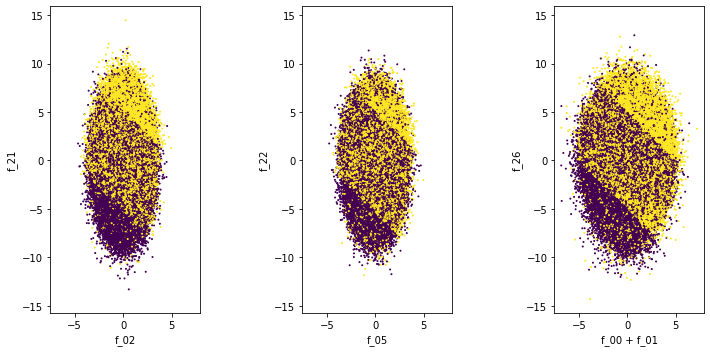

In [21]:


plt.figure(figsize=(11, 5))


ax = plt.subplot(1, 3, 1)
ax.scatter(train['f_02'], train['f_21'], s=1,
           c=train.target)
ax.set_xlabel('f_02')
ax.set_ylabel('f_21')
ax.set_aspect('equal')
ax0 = ax

ax = plt.subplot(1, 3, 2, sharex=ax0, sharey=ax0)
ax.scatter(train['f_05'], train['f_22'], s=1,
           c=train.target)
ax.set_xlabel('f_05')
ax.set_ylabel('f_22')
ax.set_aspect('equal')

ax = plt.subplot(1, 3, 3, sharex=ax0, sharey=ax0)
ax.scatter(train['f_00'] + train['f_01'], train['f_26'], s=1,
           c=train.target)
ax.set_xlabel('f_00 + f_01')
ax.set_ylabel('f_26')
ax.set_aspect('equal')

plt.tight_layout(w_pad=1.0)
plt.savefig('three-projections.png')
plt.show()

# Lightgbm Model

In [22]:
import lightgbm as lgb

from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.metrics import roc_auc_score

oof = np.zeros(len(train))
pred = np.zeros(len(test))

skf = StratifiedKFold(n_splits=5)

for i, (tidx, vidx) in enumerate(skf.split(X_train, y_train)):
    x_tr, x_val = X_train.iloc[tidx], X_train.iloc[vidx]
    y_tr, y_val = y_train.iloc[tidx], y_train.iloc[vidx]
    
    print('Fold ', i+1)
    print('*' * 60)
    
    clf = lgb.LGBMClassifier(
        n_estimators = 2000,
        learning_rate = 0.2,
        #max_depth = 9,
        subsample = 0.8,
        colsample_bytree = 0.8,
        reg_alpha = 0.5,
        reg_lambda = 0.5,
        random_state = 2022,
        importance_type = 'gain',
    
    )
    
    clf.fit(x_tr, y_tr, eval_set = [(x_tr, y_tr),(x_val, y_val)], verbose = 400, 
           early_stopping_rounds=50, eval_metric= 'auc')
    
    oof[vidx] = clf.predict_proba(x_val)[:,1]
    pred += clf.predict_proba(X_test)[:,1]/skf.n_splits
    
print('oof auc: ', roc_auc_score(y_train, oof))   

Fold  1
************************************************************
[400]	training's auc: 0.996252	training's binary_logloss: 0.0892421	valid_1's auc: 0.994769	valid_1's binary_logloss: 0.0997451
[800]	training's auc: 0.99812	training's binary_logloss: 0.0644084	valid_1's auc: 0.995917	valid_1's binary_logloss: 0.0844161
[1200]	training's auc: 0.999011	training's binary_logloss: 0.0503678	valid_1's auc: 0.996241	valid_1's binary_logloss: 0.0795286
Fold  2
************************************************************
[400]	training's auc: 0.996052	training's binary_logloss: 0.0914156	valid_1's auc: 0.994802	valid_1's binary_logloss: 0.100232
[800]	training's auc: 0.998095	training's binary_logloss: 0.0651666	valid_1's auc: 0.996102	valid_1's binary_logloss: 0.0833029
Fold  3
************************************************************
[400]	training's auc: 0.996092	training's binary_logloss: 0.0907735	valid_1's auc: 0.994756	valid_1's binary_logloss: 0.100116
[800]	training's auc: 0.998

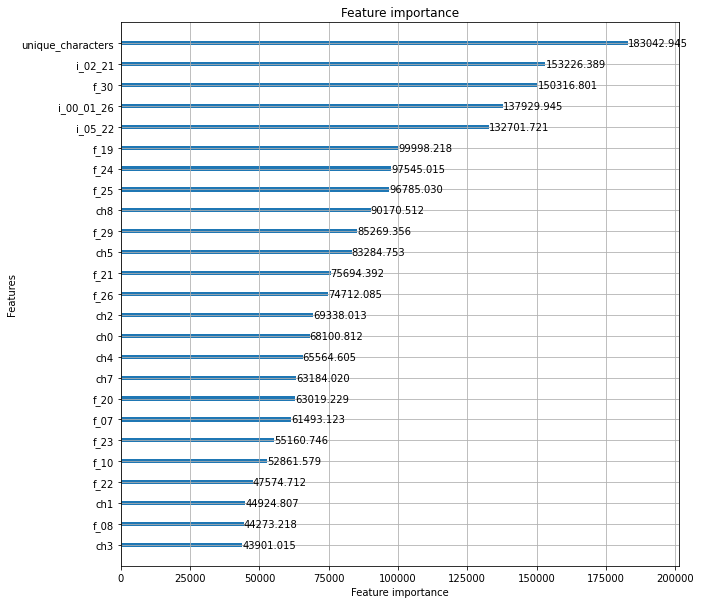

In [23]:
lgb.plot_importance(clf, max_num_features = 25, figsize = (10,10))
plt.show()

# Submission

In [24]:
sub['target'] = pred

sub.to_csv('sub_lgbm.csv', index = False)

sub.describe()


,id,target
count,7.000000e+05,7.000000e+05
mean,1.250000e+06,4.861087e-01
std,2.020727e+05,4.704619e-01
min,9.000000e+05,3.018349e-16
25%,1.075000e+06,1.577216e-03
50%,1.250000e+06,3.421392e-01
75%,1.424999e+06,9.984869e-01
max,1.599999e+06,1.000000e+00


In [25]:
sub

,id,target
0,900000,9.999903e-01
1,900001,9.996716e-01
2,900002,8.488319e-11
3,900003,1.552912e-04
4,900004,9.992830e-01
...,...,...
699995,1599995,6.684468e-01
699996,1599996,9.991618e-01
699997,1599997,9.697022e-02
699998,1599998,7.510137e-05
